# Financial Distress Prediction

### TABLE OF CONTENTS

[1. Introduction](#one)  
[2. Data Pre-processing](#two)  
[3. Data Exploration](#three)  
[4. Model Building](#four)  
[5. Validation](#five)  
[6. Summary](#six)  
[7. Future Works](#seven)  
[References](#references)  

---

## 1. Introduction <a class="anchor" id="one"></a>

Predictive algorithms are increasingly used in business today in order to gain competitive advantages. With a specific problem and appropriate datasets, they helps business to forecast what is the best action course to follow. Decisions, thus, are made based on data-driven approach (rather than "intuition" and "experience").

In this report, we are going to use a Kaggle dataset (see [1]) to predict financial distress of a person, given their history, thus, facilitating the bank to decide if they should proceed with this person.

---

## 2. Data Pre-processing <a class="anchor" id="two"></a>

In [1]:
# Necessary imports.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

In [2]:
# Necessary configs.
# Disable printing scientific notation.
np.set_printoptions(suppress=True)

In [3]:
train_dataset = pd.read_csv("cs-training.csv", header = "infer", sep = ",", encoding = "utf-8")

In [4]:
train_dataset.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


The original dataset also includes "Data Dictionary.xls", which describes the features. The data needs to be double-checked if it follows the format expectation.

* **SeriousDlqin2yrs**: Person experienced 90 days past due delinquency or worse. Yes/No.
  + Check: The values should contain either 1 or 0.

In [5]:
np.sort(train_dataset.loc[:, 'SeriousDlqin2yrs'].unique())

array([0, 1], dtype=int64)

* **RevolvingUtilizationOfUnsecuredLines**: Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits. Percentage.
  + Check: Positive real numbers from 0 to 1.

In [6]:
np.sort(train_dataset.loc[:, 'RevolvingUtilizationOfUnsecuredLines'].unique())

array([     0.        ,      0.00000837,      0.00000993, ...,
        22198.        ,  29110.        ,  50708.        ])

This seems strange! "Data Dictionary.xls" explained the meaning behind this feature, but not how this feature is presented. The Kaggle Discussion Forum for this dataset (see [1], [2]) gave no actionable clue on this.

In [7]:
((train_dataset.loc[:, 'RevolvingUtilizationOfUnsecuredLines'] > 1).sum() / train_dataset.shape[0])

0.02214

About 2.21% of data have this issue. There is no clear explanation of how the data is computed. So, it is advised to keep "as is". The good news is this column contains neither NULL/NA/NaN/Blank nor categorical data.

* **age**: Age of borrower in years. Integer.
  + Check: Positive natural numbers from 1 to, let's say, 122. See [4].

In [8]:
np.sort(train_dataset.loc[:, 'age'].unique())

array([  0,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 101, 102, 103, 105, 107, 109], dtype=int64)

The "0" age is likely erroneous, partly because no one can be 0 year old, and also because we can see an upward trend incremented by 1 from 21 (e.g.: 21, 22, 23), meaning that from 0 to 21, there is a big jump in value for no reason. So, rows associated with age "0" should be removed. However, let's first check how many percent of data are affected by this.

In [9]:
(train_dataset.loc[:, 'age'] == 0).sum()

1

The whole dataset has this number of rows:

In [10]:
train_dataset.shape[0]

150000

No need for second thought. This case must be filtered out.

In [11]:
train_dataset = train_dataset[train_dataset.loc[:, 'age'] != 0]

* **NumberOfTime30-59DaysPastDueNotWorse**: Number of times borrower has been 30-59 days past due but no worse in the last 2 years. Integer.
  + Check: Positive natural numbers, including 0.

In [12]:
np.sort(train_dataset.loc[:, 'NumberOfTime30-59DaysPastDueNotWorse'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 96, 98], dtype=int64)

* **DebtRatio**: Monthly debt payments, alimony,living costs divided by monthy gross income. Percentage.
  + Check: Positive real numbers from 0 to 1.

In [13]:
np.sort(train_dataset.loc[:, 'DebtRatio'].unique())

array([      0.       ,       0.000026 ,       0.0000369, ...,
        307001.       ,  326442.       ,  329664.       ])

It looks like this issue is similar to the column "RevolvingUtilizationOfUnsecuredLines", where the percentage is expected to be within the range of [0,1]. Again, there is no clue in the Dataset description or Kaggle Forum on treating this glitch. So it is kept "as is".

In [14]:
# For informational purpose.
((train_dataset.loc[:, 'DebtRatio'] > 1).sum() / train_dataset.shape[0])

0.23424822832152215

* **MonthlyIncome**: Monthly income. Real.
  + Check: Positive real numbers.

In [15]:
np.sort(train_dataset.loc[:, 'MonthlyIncome'].unique())

array([       0.,        1.,        2., ...,  1794060.,  3008750.,
             nan])

Because of having **nan**, let's check how many percents of data there are that have nan in this column:

In [16]:
train_dataset.loc[:, 'MonthlyIncome'].isna().sum() / train_dataset.shape[0]

0.19820798805325368

About 20% of data within this column is NaN. Therefore, it cannot just be removed, and must be imputed. There are many methods for data imputation. For example, using Regression Model (Build a Regression model, given the remaining variables. Then, make use of that model to predict the missing values). In this case, a simpler approach is preferred: calculate the mean value within the column, and replace the missing values with that mean value.

In [17]:
from sklearn.preprocessing import Imputer
imp_monthly_income = Imputer(missing_values=np.nan, strategy='mean')
non_nan_values = imp_monthly_income.fit_transform(train_dataset.loc[:, ['MonthlyIncome']])
train_dataset.loc[:, ['MonthlyIncome']] = non_nan_values
# Double check
np.isnan(non_nan_values).sum()

0

* **NumberOfOpenCreditLinesAndLoans**: Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards). Integer.
  + Check: Positive natural numbers.

In [18]:
np.sort(train_dataset.loc[:, 'NumberOfOpenCreditLinesAndLoans'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 56, 57, 58], dtype=int64)

* **NumberOfTimes90DaysLate**: Number of times borrower has been 90 days or more past due.
  + Check: Positive natural numbers.

In [19]:
np.sort(train_dataset.loc[:, 'NumberOfTimes90DaysLate'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17,
       96, 98], dtype=int64)

* **NumberRealEstateLoansOrLines**: Number of mortgage and real estate loans including home equity lines of credit. Integer.
  + Check: Positive natural numbers.

In [20]:
np.sort(train_dataset.loc[:, 'NumberRealEstateLoansOrLines'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 23, 25, 26, 29, 32, 54], dtype=int64)

* **NumberOfTime60-89DaysPastDueNotWorse**: Number of times borrower has been 60-89 days past due but no worse in the last 2 years. Integer.
  + Check: Positive natural numbers.

In [21]:
np.sort(train_dataset.loc[:, 'NumberOfTime60-89DaysPastDueNotWorse'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 96, 98], dtype=int64)

* **NumberOfDependents**: Number of dependents in family excluding themselves (spouse, children etc.). Integer.
  + Check: Positive natural numbers.

In [22]:
np.sort(train_dataset.loc[:, 'NumberOfDependents'].unique())

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        13.,  20.,  nan])

In [23]:
train_dataset.loc[:, 'NumberOfDependents'].isna().sum() / train_dataset.shape[0]

0.026160174401162674

Again, it would be better if the nan values can be replaced with average values.

In [24]:
imp_number_of_dependent = Imputer(missing_values=np.nan, strategy='mean')
non_nan_values = imp_number_of_dependent.fit_transform(train_dataset.loc[:, ['NumberOfDependents']])
train_dataset.loc[:, ['NumberOfDependents']] = non_nan_values
# Double check
np.isnan(non_nan_values).sum()

0

Lastly, the first column (index column) has no contributions to building the model, so it should be removed.

In [25]:
train_dataset.drop(train_dataset.columns[0], axis=1, inplace=True)

In [26]:
train_dataset.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


Visibly, the target value (dependent variable) is "SeriousDlqin2yrs". Remaining independent variables are going to be used to predict/classify the target value.

---

## 3. Data Exploration <a class="anchor" id="three"></a>

Some statistics:

In [27]:
train_dataset.shape

(149999, 11)

In [28]:
train_dataset.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,149999.000000,149999.000000,149999.000000,149999.000000,149999.000000,1.499990e+05,149999.000000,149999.000000,149999.000000,149999.000000,149999.000000
mean,0.066840,6.048472,52.295555,0.421029,353.007426,6.670227e+03,8.452776,0.265975,1.018233,0.240388,0.757214
std,0.249746,249.756203,14.771298,4.192795,2037.825113,1.288049e+04,5.145964,4.169318,1.129772,4.155193,1.100403
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154176,52.000000,0.000000,0.366503,6.600000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559044,63.000000,0.000000,0.868257,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


One way to potentially improve the performance of a machine learning model is to have non-correlated features. More features also require more computation and system resources (RAM, CPU, etc.) Let's check the correlation between those features to see if we can remove any of them.

In [29]:
corr = train_dataset.loc[:, train_dataset.columns[1:]].corr().as_matrix()
corr

array([[ 1.        , -0.00589891, -0.00131348,  0.00396118,  0.006565  ,
        -0.01128081, -0.00106125,  0.00623485, -0.00104784,  0.00153893],
       [-0.00589891,  1.        , -0.06299453,  0.02418473,  0.0329842 ,
         0.14770035, -0.06100876,  0.03317225, -0.05716322, -0.20808514],
       [-0.00131348, -0.06299453,  1.        , -0.00654176, -0.0076355 ,
        -0.05531184,  0.98360282, -0.03056541,  0.98700557, -0.00252634],
       [ 0.00396118,  0.02418473, -0.00654176,  1.        , -0.00535496,
         0.04956478, -0.00831971,  0.12004734, -0.00753317, -0.0382864 ],
       [ 0.006565  ,  0.0329842 , -0.0076355 , -0.00535496,  1.        ,
         0.0823188 , -0.00948358,  0.11382389, -0.008259  ,  0.05854302],
       [-0.01128081,  0.14770035, -0.05531184,  0.04956478,  0.0823188 ,
         1.        , -0.07998461,  0.43396279, -0.07107697,  0.06451089],
       [-0.00106125, -0.06100876,  0.98360282, -0.00831971, -0.00948358,
        -0.07998461,  1.        , -0.04520496

In [30]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical');
    plt.yticks(range(len(corr.columns)), corr.columns);

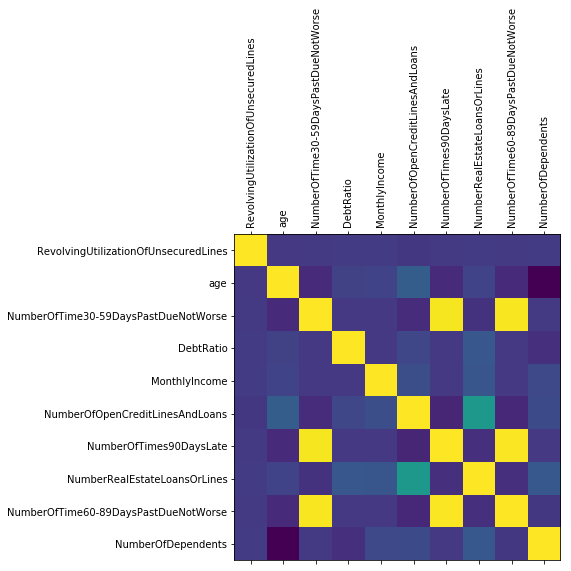

In [31]:
%matplotlib inline
plot_corr(train_dataset.loc[:, train_dataset.columns[1:]], 6)

High correlation can be seen between those columns: "NumberOfTimes90DaysLate", "NumberOfTime30-59DaysPastDueNotWorse" and "NumberOfTime60-89DaysPastDueNotWorse". Intuitively, by reading the feature names, one can easily understand why they are highly correlated. There is still a slight chance that even those having high correlation can turn out to be very different. See [5] for "**Anscombe's quartet**". Let's draw some plots to feel the data better.

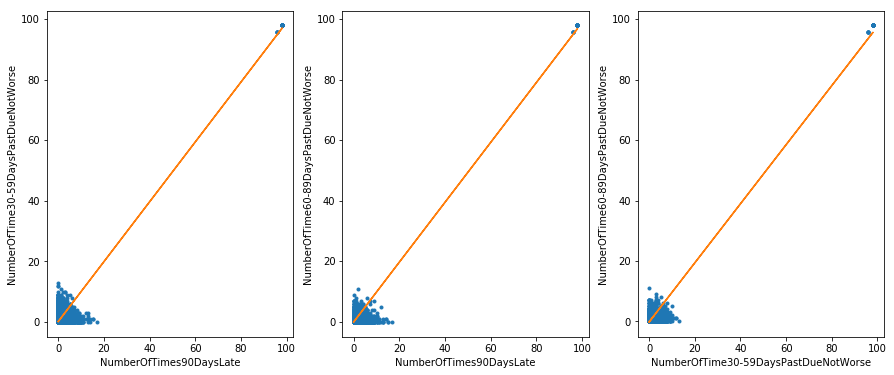

In [32]:
%matplotlib inline
temp_data_frame = train_dataset.loc[:, ['NumberOfTimes90DaysLate', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse']]

def drawSubplot(x, y):
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, y, '.')
    plt.plot(x, m*x + b, '-')
    plt.xlabel(x.name, fontsize=10)
    plt.ylabel(y.name, fontsize=10)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,6))

# NumberOfTimes90DaysLate vs. NumberOfTime30-59DaysPastDueNotWorse
plt.subplot(1, 3, 1)
drawSubplot(temp_data_frame.iloc[:, 0], temp_data_frame.iloc[:, 1])

# NumberOfTimes90DaysLate vs. NumberOfTime60-89DaysPastDueNotWorse
plt.subplot(1, 3, 2)
drawSubplot(temp_data_frame.iloc[:, 0], temp_data_frame.iloc[:, 2])

# NumberOfTime30-59DaysPastDueNotWorse vs. NumberOfTime60-89DaysPastDueNotWorse
plt.subplot(1, 3, 3)
drawSubplot(temp_data_frame.iloc[:, 1], temp_data_frame.iloc[:, 2])

plt.show()

Although the points are not perfectly collinear (lying on a single line), it is understandable that they have high correlation as when a feature has a small value, the other feature also has an approximately small value. The all 3 features seemingly contribute equally to the to-be-built model.

In short, given the limited description on features, we choose to keep "NumberOfTimes90DaysLate" and remove the other two.

In [33]:
train_dataset.drop(['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse'], axis=1, inplace=True)

The **clean** data is ready to feed into machine learning algorithms.

In [34]:
train_dataset.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfDependents
0,1,0.766127,45,0.802982,9120.0,13,0,6,2.0
1,0,0.957151,40,0.121876,2600.0,4,0,0,1.0
2,0,0.658180,38,0.085113,3042.0,2,1,0,0.0
3,0,0.233810,30,0.036050,3300.0,5,0,0,0.0
4,0,0.907239,49,0.024926,63588.0,7,0,1,0.0


In [35]:
train_dataset.dtypes

SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfDependents                      float64
dtype: object

One question may rise up, concerning "age". **At what age** do people tend to suffer from financial distress? If grouping simply by age, the resultant trend may be fluctuating because of overfitting this dataset. It makes more senses to divide ages into groups, i.e.: [20-30), [30-40), etc.

In [36]:
def groupAge(x):
    if (x>= 20 and x < 30):
        return "[20-30)"
    elif  (x>= 30 and x < 40):
        return "[30-40)"
    elif  (x>=40 and x < 50):
        return "[40-50)"
    elif  (x>=50 and x < 60):
        return "[50-60)"
    elif  (x>=60 and x < 70):
        return "[60-70)"
    elif  (x>=70 and x<80):
        return "[70-80)"
    elif  (x>=80 and x < 90):
        return "[80-90)"
    elif  (x>=90 and x < 100):
        return "[90-100)"
    elif  (x>=100 and x< 110):
        return "[100-110)"
    else:
        return "unknown"

group_age = train_dataset.loc[:, 'age'].apply(lambda x: groupAge(x))

# Create a temporary dataframe.
df_age_and_distress = train_dataset.loc[:, ['SeriousDlqin2yrs']]
# Add new column.
df_age_and_distress.loc[:, 'group_age'] = group_age

In [37]:
financial_distress_by_age_group = df_age_and_distress.groupby('group_age')

In [38]:
(financial_distress_by_age_group.sum() / financial_distress_by_age_group.count()) * 100

,SeriousDlqin2yrs
group_age,
[100-110),7.692308
[20-30),11.734694
[30-40),10.072036
[40-50),8.371877
[50-60),6.453075
[60-70),3.632590
[70-80),2.433645
[80-90),2.048780
[90-100),1.928783


Some comments:
* The age groups where people have most and second highest probabilty of financial distress: [20-30), [30-40).
* This trend is reduced overtime.
* A surprising finding: when people reach 100 and above, their probability of having financial distress actually increases!

---

## 4. Model Building <a class="anchor" id="four"></a>

The most optimal machine learning algorithm for a specific problem might not be figured out without trial-and-error. One algorithm is good for this problem and/or this dataset can turn out to be less ideal for other problem and/or other datasets. Linear Regression is good if the decision boundary is linearly separable. Decision Tree, in the other hand, assumes the boundary is parallel to axes ("features").

In reality, in order to achieve high performance, one should focus on, first and foremost, data quality and quantity. In general, the more data, the better. Secondly, using domain knowledge to engineer promising features for the specific business problem. After that, one reasonably uses a variety of Machine Learning algorithms to build models. Each algorithm involves many hyper-parameters to be tuned. Carrying out a lot of trial-and-error; eventually, an optimal algorithm (with its optimal hyper-parameters) begins to surface.

In this case, **Random Forest (RF)** will be employed to tackle our prediction problem. RF is well-known to give decent performance. It can run **in parallel effectively** (each tree is built separately). RF is also less proned to over-fitting.

In [39]:
rfc = RandomForestClassifier(n_jobs=-1, oob_score = True, random_state=123)

"""
See [7] for all tunable hyper-parameters.
See [8] for recommended hyper-parameters.

n_estimators: The number of trees in the forest => The more, the better, but more resource usage.
max_features: The number of features to consider when looking for the best split.
criterion: The function to measure the quality of a split.
max_depth: The maximum depth of the tree => The deeper, the more overfitting (capture noise!)
"""
param_grid = { 
           "n_estimators" : [300, 500],
           "max_features" : [3, 6],
           "criterion" : ["gini", "entropy"],
           "max_depth": [4, 6, 8]}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv = 5, verbose=10)

CV_rfc.fit(train_dataset.iloc[:, 1:], train_dataset.iloc[:, 0])
print(CV_rfc.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] criterion=gini, max_depth=4, max_features=3, n_estimators=300 ...
[CV]  criterion=gini, max_depth=4, max_features=3, n_estimators=300, score=0.9345688477050765, total=   9.3s
[CV] criterion=gini, max_depth=4, max_features=3, n_estimators=300 ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s remaining:    0.0s


[CV]  criterion=gini, max_depth=4, max_features=3, n_estimators=300, score=0.9341666666666667, total=   8.6s
[CV] criterion=gini, max_depth=4, max_features=3, n_estimators=300 ...


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.4s remaining:    0.0s


[CV]  criterion=gini, max_depth=4, max_features=3, n_estimators=300, score=0.9349333333333333, total=   8.7s
[CV] criterion=gini, max_depth=4, max_features=3, n_estimators=300 ...


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.9s remaining:    0.0s


[CV]  criterion=gini, max_depth=4, max_features=3, n_estimators=300, score=0.9348644954831827, total=   8.5s
[CV] criterion=gini, max_depth=4, max_features=3, n_estimators=300 ...


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   38.3s remaining:    0.0s


[CV]  criterion=gini, max_depth=4, max_features=3, n_estimators=300, score=0.9339977999266642, total=   8.7s
[CV] criterion=gini, max_depth=4, max_features=3, n_estimators=500 ...


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   47.6s remaining:    0.0s


[CV]  criterion=gini, max_depth=4, max_features=3, n_estimators=500, score=0.9343021899270024, total=  14.1s
[CV] criterion=gini, max_depth=4, max_features=3, n_estimators=500 ...


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.0min remaining:    0.0s


[CV]  criterion=gini, max_depth=4, max_features=3, n_estimators=500, score=0.9339, total=  13.8s
[CV] criterion=gini, max_depth=4, max_features=3, n_estimators=500 ...


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.3min remaining:    0.0s


[CV]  criterion=gini, max_depth=4, max_features=3, n_estimators=500, score=0.9345666666666667, total=  13.9s
[CV] criterion=gini, max_depth=4, max_features=3, n_estimators=500 ...


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.5min remaining:    0.0s


[CV]  criterion=gini, max_depth=4, max_features=3, n_estimators=500, score=0.9347978265942198, total=  13.8s
[CV] criterion=gini, max_depth=4, max_features=3, n_estimators=500 ...


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.8min remaining:    0.0s


[CV]  criterion=gini, max_depth=4, max_features=3, n_estimators=500, score=0.9341311377045901, total=  13.8s
[CV] criterion=gini, max_depth=4, max_features=6, n_estimators=300 ...
[CV]  criterion=gini, max_depth=4, max_features=6, n_estimators=300, score=0.9349688343721876, total=  12.1s
[CV] criterion=gini, max_depth=4, max_features=6, n_estimators=300 ...
[CV]  criterion=gini, max_depth=4, max_features=6, n_estimators=300, score=0.9360666666666667, total=  12.1s
[CV] criterion=gini, max_depth=4, max_features=6, n_estimators=300 ...
[CV]  criterion=gini, max_depth=4, max_features=6, n_estimators=300, score=0.9352666666666667, total=  12.2s
[CV] criterion=gini, max_depth=4, max_features=6, n_estimators=300 ...
[CV]  criterion=gini, max_depth=4, max_features=6, n_estimators=300, score=0.9369312310410347, total=  12.1s
[CV] criterion=gini, max_depth=4, max_features=6, n_estimators=300 ...
[CV]  criterion=gini, max_depth=4, max_features=6, n_estimators=300, score=0.9365978865962199, total

[CV]  criterion=gini, max_depth=8, max_features=6, n_estimators=500, score=0.9350688310389653, total=  33.9s
[CV] criterion=gini, max_depth=8, max_features=6, n_estimators=500 ...
[CV]  criterion=gini, max_depth=8, max_features=6, n_estimators=500, score=0.9357666666666666, total=  34.3s
[CV] criterion=gini, max_depth=8, max_features=6, n_estimators=500 ...
[CV]  criterion=gini, max_depth=8, max_features=6, n_estimators=500, score=0.9358666666666666, total=  34.1s
[CV] criterion=gini, max_depth=8, max_features=6, n_estimators=500 ...
[CV]  criterion=gini, max_depth=8, max_features=6, n_estimators=500, score=0.9367978932631088, total=  34.1s
[CV] criterion=gini, max_depth=8, max_features=6, n_estimators=500 ...
[CV]  criterion=gini, max_depth=8, max_features=6, n_estimators=500, score=0.9368645621520717, total=  33.9s
[CV] criterion=entropy, max_depth=4, max_features=3, n_estimators=300 
[CV]  criterion=entropy, max_depth=4, max_features=3, n_estimators=300, score=0.9342355254824839, to

[CV]  criterion=entropy, max_depth=8, max_features=3, n_estimators=300, score=0.9354, total=  15.4s
[CV] criterion=entropy, max_depth=8, max_features=3, n_estimators=300 
[CV]  criterion=entropy, max_depth=8, max_features=3, n_estimators=300, score=0.9357, total=  15.5s
[CV] criterion=entropy, max_depth=8, max_features=3, n_estimators=300 
[CV]  criterion=entropy, max_depth=8, max_features=3, n_estimators=300, score=0.9369978999299977, total=  15.4s
[CV] criterion=entropy, max_depth=8, max_features=3, n_estimators=300 
[CV]  criterion=entropy, max_depth=8, max_features=3, n_estimators=300, score=0.9365645521517384, total=  15.5s
[CV] criterion=entropy, max_depth=8, max_features=3, n_estimators=500 
[CV]  criterion=entropy, max_depth=8, max_features=3, n_estimators=500, score=0.935802139928669, total=  25.5s
[CV] criterion=entropy, max_depth=8, max_features=3, n_estimators=500 
[CV]  criterion=entropy, max_depth=8, max_features=3, n_estimators=500, score=0.9355, total=  25.6s
[CV] crite

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 41.9min finished


{'criterion': 'gini', 'max_depth': 8, 'max_features': 3, 'n_estimators': 300}


Given the found optimal hyper-parameters {'criterion': 'gini', 'max_depth': 8, 'max_features': 3, 'n_estimators': 300}, we start building the final RF model.

In [40]:
rf_final = RandomForestClassifier(n_jobs=-1, criterion='gini', max_depth=8, max_features=3, n_estimators=300, oob_score=True, random_state=123)
rf_final.fit(train_dataset.iloc[:, 1:], train_dataset.iloc[:, 0])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

This RF model can be used to predict the target value in the training dataset. However, one should expect that the accuracy will be **optimistically high** as the model **learned through the training dataset**!

In [41]:
preds = rf_final.predict(train_dataset.iloc[:, 1:])

Confusion matrix:

In [49]:
pd.crosstab(index=preds, columns=train_dataset.iloc[:, 0], rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,139311,8428
1,662,1598


The accruracy is: ~93.94%! This accuracy is **not representative** for the RF model despite that this model is the final one, and will be used against the test set. The **appropriate accuracy of the model upon the training set** should be acquired from Cross Validation, specifically from the GridSearchCV in our case.

It is also worrying that the classifier misclassified 8428 people, who **will suffer financial distress**, as "non-distressable", five times bigger than correct 1598 number. To the bank, this result is not appealing.

Mitigation:

* Improve the accuracy by trying more hyper-parameters.  
* Adjust decision threshold by using `predict_prob()`.

In [43]:
# Mean cross-validated score of the best_estimator
print(CV_rfc.best_score_)

0.936272908486


It is worth noting that by guessing all people as "non-distressable" within the training dataset, we easily have this accuracy:

In [44]:
(train_dataset.loc[:, 'SeriousDlqin2yrs'].count() - train_dataset.loc[:, 'SeriousDlqin2yrs'].sum()) / train_dataset.loc[:, 'SeriousDlqin2yrs'].count()

0.93315955439702936

It means that our model's performance is **only marginally** better than weight-based guessing.

And what are the **best predictors**?

In [45]:
feature_importance_df = pd.DataFrame({'Feature': train_dataset.columns[1:], 'Importance': rf_final.feature_importances_})
feature_importance_df.sort_values('Importance', ascending=False)

,Feature,Importance
5,NumberOfTimes90DaysLate,0.509716
0,RevolvingUtilizationOfUnsecuredLines,0.308455
1,age,0.046986
2,DebtRatio,0.041487
4,NumberOfOpenCreditLinesAndLoans,0.033857
3,MonthlyIncome,0.031604
6,NumberRealEstateLoansOrLines,0.018179
7,NumberOfDependents,0.009715


---

## 5. Validation <a class="anchor" id="five"></a>

The original dataset is already split into train/test. "cs-training.csv" for training, which has been used above. "cs-test.csv" for testing. Before validation, the test data must also be cleaned in the same way the training data passed through. That is,

* Remove first index column.
* Remove 'NumberOfTime30-59DaysPastDueNotWorse' and 'NumberOfTime60-89DaysPastDueNotWorse'.
* Impute NaN in 'MonthlyIncome' and 'NumberOfDependents' **using the Imputers created**.

However, in the test set, there is no label for "SeriousDlqin2yrs". So, we cannot measure the accuracy of the RF model upon the test set. Normally, this accuracy is the **reported** accuracy. If both numbers are close to each other, the generalization goal is achieved.

Note: The dataset "GiveMeSomeCredit" is given as a contest in Kaggle. Labels in test set, thus, are hidden.

In order to benchmark the performance of each machine learning algorithm (given their best hyperparameters), AUROC (Area Under the curve of the Receiver Operating Characteristic) is used. Even though we have only used RF so far, draw the ROC and calculate AUC anyway. See Future Works.

Note: The **reported** model's performance should be measured with test set. Unfortunately, **we do not have labels for test set. So we use training set instead**.

In [46]:
probas = rf_final.predict_proba(train_dataset.iloc[:, 1:])
fpr, tpr, thresholds = roc_curve(train_dataset.iloc[:, 0], probas[:, 1])
roc_auc = auc(fpr, tpr)

AUC (AUROC):

In [47]:
roc_auc

0.85286929905459574

Given AUROC = 0.85, the used classifier (RF and its optimal hyperparameters) is categorized as "good". See [11].

ROC:

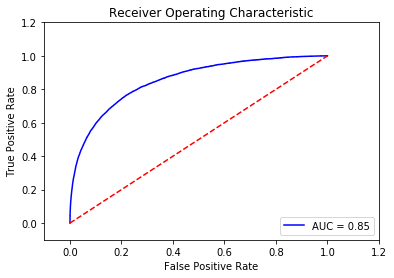

In [48]:
%matplotlib inline
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

---

## 6. Summary <a class="anchor" id="six"></a>

The business challenge of GiveMeSomeCredit (Kaggle) is to predict if a person will have financial distress in the future. Thus, if a yes, the bank should not give a loan to that person as they will not be able to pay back, making a loss for the bank. Originally, the dataset has 10 features. There are 3 features that are highly correlated; so we removed two. The machine learning algorithm used to solve this prediction problem is Random Forest, which is well-known to be decent in terms of performance.

Instead of separating the training dataset into "train/validation", we used Cross Validation (5 folds) to better estimate the model performance, given a set of hyper-parameters. GridSearchCV was used to seek optimal parameters. Although Random Forest has many tunable parameters, we focus on most common ones (`n_estimators`, `max_features`, `criterion`, `max_depth`).

The accuracy of the built RF model:
* For training set (5-Folds CV): 93.6%
* For testing set: labels not available offline.

---

## 7. Future Works <a class="anchor" id="seven"></a>

* GridSearchCV with more parameters for the `param_grid`.
  + It is suggested that `n_estimators` should be {500, 1000}.
  + Experiment with `min_samples_leaf` to reduce over-fitting.
  + Experiment with `max_depth` (deeper) because trees in RF should be fully grown. See [10]. This also improves accuracy.
* Try XGBoost (Gradient Boosting Tree) as it is popular within Kaggle Community. (See [9])
  + The draw AUC for XGBoost (Gradient Boosting Tree), compare it to RF.

---

## References <a class="anchor" id="references"></a>

[1] https://www.kaggle.com/c/GiveMeSomeCredit

[2] https://www.kaggle.com/c/GiveMeSomeCredit/discussion/918

[3] https://www.kaggle.com/c/GiveMeSomeCredit/discussion/874

[4] https://en.wikipedia.org/wiki/Oldest_people

[5] https://en.wikipedia.org/wiki/Anscombe%27s_quartet

[6] https://en.wikipedia.org/wiki/No_free_lunch_theorem

[7] http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

[8] https://stackoverflow.com/questions/36107820/how-to-tune-parameters-in-random-forest-using-scikit-learn

[9] https://en.wikipedia.org/wiki/Xgboost

[10] https://stats.stackexchange.com/questions/173390/gradient-boosting-tree-vs-random-forest

[11] https://acutecaretesting.org/en/articles/roc-curves-what-are-they-and-how-are-they-used

---

## Appendix

* My computer's resource usage when GridSearchCV is running. Note that we used `n_jobs=-1` to enable Python to exploit all CPU cores available.

![CPU](CPU.png)